✅ Step-4 coregistered inputs found:
 - D:\IIT DHANBAD M.TECH\Image_analysis\output\processed\s2_t1_coreg.tif
 - D:\IIT DHANBAD M.TECH\Image_analysis\output\processed\s2_t2_coreg.tif
 - D:\IIT DHANBAD M.TECH\Image_analysis\output\processed\s1_t1_coreg.tif
 - D:\IIT DHANBAD M.TECH\Image_analysis\output\processed\s1_t2_coreg.tif
S2 shapes: (4, 6892, 6756) (4, 6892, 6756)
S1 shapes: (2, 6892, 6756) (2, 6892, 6756)
✅ All aligned to same pixel grid.
CRS: EPSG:32643
Pixel size: (10.0, 10.0)
Otsu thresholds NDWI: T1 = -0.47289058566093445 | T2 = -0.54056715965271
✅ Optical change mask computed.
Otsu threshold VV_change (dB): 3.2518301010131836
✅ SAR flood-like change mask computed.
Saved: D:\IIT DHANBAD M.TECH\Image_analysis\output\change\ndwi_t1.tif
Saved: D:\IIT DHANBAD M.TECH\Image_analysis\output\change\ndwi_t2.tif
Saved: D:\IIT DHANBAD M.TECH\Image_analysis\output\change\water_t1_mask.tif
Saved: D:\IIT DHANBAD M.TECH\Image_analysis\output\change\water_t2_mask.tif
Saved: D:\IIT DHANBAD M.T

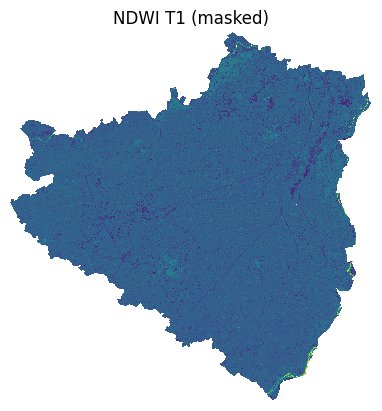

Saved: D:\IIT DHANBAD M.TECH\Image_analysis\output\figures\ndwi_t1.png


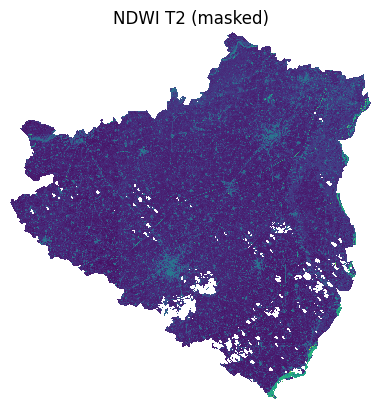

Saved: D:\IIT DHANBAD M.TECH\Image_analysis\output\figures\ndwi_t2.png


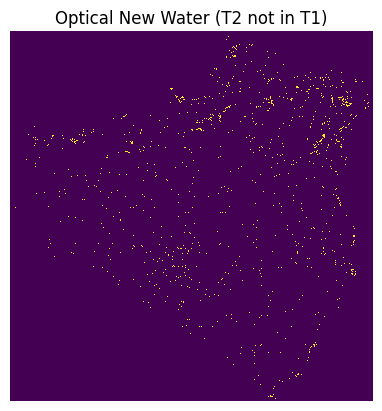

Saved: D:\IIT DHANBAD M.TECH\Image_analysis\output\figures\optical_new_water_mask.png


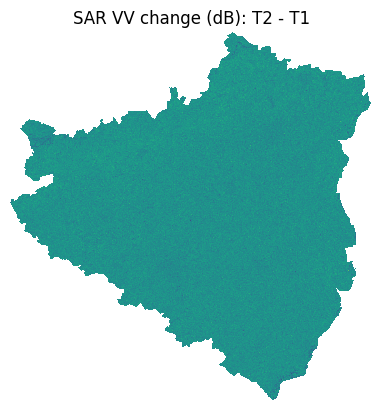

Saved: D:\IIT DHANBAD M.TECH\Image_analysis\output\figures\vv_change.png


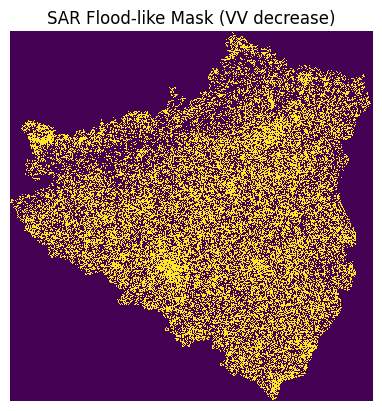

Saved: D:\IIT DHANBAD M.TECH\Image_analysis\output\figures\sar_flood_mask.png
Pixel size (m): 10.0 x 10.0
Optical new-water area (km²): 35.5792
SAR flood-like area (km²): 1155.6467

DONE ✅ Step 5 completed.
Change rasters: D:\IIT DHANBAD M.TECH\Image_analysis\output\change
Figures: D:\IIT DHANBAD M.TECH\Image_analysis\output\figures


In [3]:
# STEP 5 (NO skimage needed) ✅
# - Reads coregistered S2 + S1
# - Computes NDWI (S2) + optical new-water mask (T2 not in T1)
# - Computes SAR VV dB change + SAR flood mask
# - Saves GeoTIFF outputs to output/change/
# - Saves quick PNGs to output/figures/

from pathlib import Path
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# ----------------------------
# 0) Robust project root auto-detect
# ----------------------------
def find_project_root() -> Path:
    cwd = Path.cwd().resolve()
    for base in [cwd] + list(cwd.parents):
        if (base / "output" / "processed").exists():
            return base
        if (base / "data" / "roi_1.geojson").exists():
            return base
    return cwd

project_root = find_project_root()
if project_root.name.lower() == "notebooks":
    project_root = project_root.parent

proc_dir = project_root / "output" / "processed"
out_change = project_root / "output" / "change"
out_fig = project_root / "output" / "figures"
out_change.mkdir(parents=True, exist_ok=True)
out_fig.mkdir(parents=True, exist_ok=True)

s2_t1 = proc_dir / "s2_t1_coreg.tif"
s2_t2 = proc_dir / "s2_t2_coreg.tif"
s1_t1 = proc_dir / "s1_t1_coreg.tif"
s1_t2 = proc_dir / "s1_t2_coreg.tif"

for p in [s2_t1, s2_t2, s1_t1, s1_t2]:
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p}")

print("✅ Step-4 coregistered inputs found:")
print(" -", s2_t1)
print(" -", s2_t2)
print(" -", s1_t1)
print(" -", s1_t2)

# ----------------------------
# 1) Otsu threshold (pure NumPy) - replaces skimage.threshold_otsu
# ----------------------------
def otsu_threshold(values: np.ndarray, nbins: int = 256) -> float:
    """
    Pure numpy Otsu threshold.
    values: 1D array of finite values
    """
    values = values[np.isfinite(values)]
    if values.size < 100:
        # fallback if too few points
        return float(np.nanmedian(values)) if values.size else 0.0

    vmin = float(np.min(values))
    vmax = float(np.max(values))
    if np.isclose(vmin, vmax):
        return vmin

    hist, bin_edges = np.histogram(values, bins=nbins, range=(vmin, vmax))
    hist = hist.astype(np.float64)

    # probabilities
    p = hist / np.sum(hist)
    omega = np.cumsum(p)  # cumulative class probability
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    mu = np.cumsum(p * bin_mids)  # cumulative class mean
    mu_t = mu[-1]  # global mean

    # between-class variance
    denom = omega * (1.0 - omega)
    denom[denom == 0] = np.nan
    sigma_b2 = ((mu_t * omega - mu) ** 2) / denom

    idx = np.nanargmax(sigma_b2)
    return float(bin_mids[idx])

# ----------------------------
# 2) Read rasters
# ----------------------------
def read_stack(path: Path):
    with rasterio.open(path) as src:
        arr = src.read()  # (bands, rows, cols)
        profile = src.profile
    return arr, profile

s2_1, s2_prof = read_stack(s2_t1)
s2_2, _ = read_stack(s2_t2)
s1_1, s1_prof = read_stack(s1_t1)
s1_2, _ = read_stack(s1_t2)

print("S2 shapes:", s2_1.shape, s2_2.shape)
print("S1 shapes:", s1_1.shape, s1_2.shape)

# Basic alignment checks
assert s2_1.shape[1:] == s2_2.shape[1:], "S2 T1/T2 not aligned"
assert s1_1.shape[1:] == s1_2.shape[1:], "S1 T1/T2 not aligned"
assert s2_1.shape[1:] == s1_1.shape[1:], "S2 vs S1 not aligned"

print("✅ All aligned to same pixel grid.")
print("CRS:", s2_prof.get("crs"))
print("Pixel size:", (s2_prof["transform"].a, -s2_prof["transform"].e))

# ----------------------------
# 3) OPTICAL (Sentinel-2): NDWI + new water mask
# Band mapping in your S2 file:
#  band1=B03 (Green), band2=B08 (NIR), band3=SCL, band4=cloudMask (1=clear, 0=cloud)
# ----------------------------
nodata_s2 = s2_prof.get("nodata", -9999.0)

GREEN_1 = s2_1[0].astype("float32")
NIR_1   = s2_1[1].astype("float32")
CM_1    = s2_1[3].astype("float32")  # cloudMask

GREEN_2 = s2_2[0].astype("float32")
NIR_2   = s2_2[1].astype("float32")
CM_2    = s2_2[3].astype("float32")

def ndwi(g, n):
    denom = g + n
    out = np.full(g.shape, np.nan, dtype="float32")
    valid = np.isfinite(denom) & (np.abs(denom) > 1e-6)
    out[valid] = (g[valid] - n[valid]) / denom[valid]
    return out

def apply_masks(g, n, cm):
    g = g.copy()
    n = n.copy()
    bad = (g == nodata_s2) | (n == nodata_s2) | (cm < 0.5)
    g[bad] = np.nan
    n[bad] = np.nan
    return g, n

GREEN_1m, NIR_1m = apply_masks(GREEN_1, NIR_1, CM_1)
GREEN_2m, NIR_2m = apply_masks(GREEN_2, NIR_2, CM_2)

NDWI_1 = ndwi(GREEN_1m, NIR_1m)
NDWI_2 = ndwi(GREEN_2m, NIR_2m)

vals1 = NDWI_1[np.isfinite(NDWI_1)]
vals2 = NDWI_2[np.isfinite(NDWI_2)]

if vals1.size < 1000 or vals2.size < 1000:
    print("⚠️ Warning: Too few valid S2 pixels (clouds/nodata). Results may be weak.")

thr1 = otsu_threshold(vals1)
thr2 = otsu_threshold(vals2)

print("Otsu thresholds NDWI: T1 =", thr1, "| T2 =", thr2)

WATER_1 = (NDWI_1 > thr1).astype("uint8")
WATER_2 = (NDWI_2 > thr2).astype("uint8")

# New water in T2 (flood-like)
OPT_NEW_WATER = ((WATER_2 == 1) & (WATER_1 == 0)).astype("uint8")
print("✅ Optical change mask computed.")

# ----------------------------
# 4) SAR (Sentinel-1): VV dB change + flood mask
# Band mapping in your S1 file:
#  band1=VV, band2=VH
# ----------------------------
nodata_s1 = s1_prof.get("nodata", None)

VV_1 = s1_1[0].astype("float32")
VH_1 = s1_1[1].astype("float32")
VV_2 = s1_2[0].astype("float32")
VH_2 = s1_2[1].astype("float32")

def to_db(x, nodata=None):
    x = x.copy()
    if nodata is not None:
        x[x == nodata] = np.nan
    x[x <= 0] = np.nan
    return 10.0 * np.log10(x)

VV1_db = to_db(VV_1, nodata_s1)
VV2_db = to_db(VV_2, nodata_s1)
VH1_db = to_db(VH_1, nodata_s1)
VH2_db = to_db(VH_2, nodata_s1)

VV_change = VV2_db - VV1_db
VH_change = VH2_db - VH1_db

v = VV_change[np.isfinite(VV_change)]
thr_vv = otsu_threshold(v)
print("Otsu threshold VV_change (dB):", thr_vv)

# Flood-like: VV decreases (more negative)
SAR_FLOOD = (VV_change < thr_vv).astype("uint8")
print("✅ SAR flood-like change mask computed.")

# ----------------------------
# 5) Save outputs (GeoTIFF)
# ----------------------------
def write_singleband(path: Path, arr, profile, dtype, nodata_val):
    prof = profile.copy()
    prof.update(
        driver="GTiff",
        count=1,
        dtype=dtype,
        nodata=nodata_val,
        compress="deflate"
    )
    with rasterio.open(path, "w", **prof) as dst:
        dst.write(arr.astype(dtype), 1)
    print("Saved:", path)

# NDWI (float32, nodata=-9999)
ndwi_nodata = -9999.0
NDWI_1_out = np.where(np.isfinite(NDWI_1), NDWI_1, ndwi_nodata).astype("float32")
NDWI_2_out = np.where(np.isfinite(NDWI_2), NDWI_2, ndwi_nodata).astype("float32")

write_singleband(out_change / "ndwi_t1.tif", NDWI_1_out, s2_prof, "float32", ndwi_nodata)
write_singleband(out_change / "ndwi_t2.tif", NDWI_2_out, s2_prof, "float32", ndwi_nodata)

# Masks (uint8, nodata=0)
write_singleband(out_change / "water_t1_mask.tif", WATER_1, s2_prof, "uint8", 0)
write_singleband(out_change / "water_t2_mask.tif", WATER_2, s2_prof, "uint8", 0)
write_singleband(out_change / "optical_new_water_mask.tif", OPT_NEW_WATER, s2_prof, "uint8", 0)

# SAR change (float32, nodata=-9999)
sar_nodata = -9999.0
VVc_out = np.where(np.isfinite(VV_change), VV_change, sar_nodata).astype("float32")
write_singleband(out_change / "vv_db_change_t2_minus_t1.tif", VVc_out, s1_prof, "float32", sar_nodata)

write_singleband(out_change / "sar_flood_mask.tif", SAR_FLOOD, s1_prof, "uint8", 0)

print("✅ Step 5 GeoTIFF outputs written to:", out_change)

# ----------------------------
# 6) Save quick PNG figures
# ----------------------------
def save_png(name: str, arr: np.ndarray, title: str):
    plt.figure()
    plt.imshow(arr, interpolation="nearest")
    plt.title(title)
    plt.axis("off")
    out = out_fig / name
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", out)

save_png("ndwi_t1.png", NDWI_1, "NDWI T1 (masked)")
save_png("ndwi_t2.png", NDWI_2, "NDWI T2 (masked)")
save_png("optical_new_water_mask.png", OPT_NEW_WATER, "Optical New Water (T2 not in T1)")
save_png("vv_change.png", VV_change, "SAR VV change (dB): T2 - T1")
save_png("sar_flood_mask.png", SAR_FLOOD, "SAR Flood-like Mask (VV decrease)")

# ----------------------------
# 7) Area stats (km²)
# ----------------------------
px_w = abs(s2_prof["transform"].a)
px_h = abs(s2_prof["transform"].e)
pixel_area_m2 = px_w * px_h

opt_area_km2 = float(OPT_NEW_WATER.sum() * pixel_area_m2 / 1e6)
sar_area_km2 = float(SAR_FLOOD.sum() * pixel_area_m2 / 1e6)

print("Pixel size (m):", px_w, "x", px_h)
print("Optical new-water area (km²):", opt_area_km2)
print("SAR flood-like area (km²):", sar_area_km2)

print("\nDONE ✅ Step 5 completed.")
print("Change rasters:", out_change)
print("Figures:", out_fig)


In [4]:
def read_stack(path: Path):
    with rasterio.open(path) as src:
        arr = src.read()  # (bands, rows, cols)
        profile = src.profile
        return arr, profile

s2_1, s2_prof = read_stack(s2_t1)
s2_2, _ = read_stack(s2_t2)
s1_1, s1_prof = read_stack(s1_t1)
s1_2, _ = read_stack(s1_t2)

print("S2 shapes:", s2_1.shape, s2_2.shape)
print("S1 shapes:", s1_1.shape, s1_2.shape)

# All should match (same grid) because Step 4 coregistered them.
assert s2_1.shape[1:] == s2_2.shape[1:], "S2 T1/T2 not aligned"
assert s1_1.shape[1:] == s1_2.shape[1:], "S1 T1/T2 not aligned"
assert s2_1.shape[1:] == s1_1.shape[1:], "S2 vs S1 not aligned"

print("✅ All aligned to same pixel grid.")
print("CRS:", s2_prof["crs"])
print("Pixel size:", (s2_prof["transform"].a, -s2_prof["transform"].e))


S2 shapes: (4, 6892, 6756) (4, 6892, 6756)
S1 shapes: (2, 6892, 6756) (2, 6892, 6756)
✅ All aligned to same pixel grid.
CRS: EPSG:32643
Pixel size: (10.0, 10.0)


In [6]:
# S2 band meaning in your file:
# band1=B03 (Green), band2=B08 (NIR), band3=SCL, band4=cloudMask (1=clear, 0=cloud)
GREEN_1 = s2_1[0].astype("float32")
NIR_1   = s2_1[1].astype("float32")
CM_1    = s2_1[3].astype("float32")

GREEN_2 = s2_2[0].astype("float32")
NIR_2   = s2_2[1].astype("float32")
CM_2    = s2_2[3].astype("float32")

nodata = s2_prof.get("nodata", -9999)

def ndwi(g, n):
    denom = (g + n)
    out = np.full(g.shape, np.nan, dtype="float32")
    valid = np.isfinite(denom) & (np.abs(denom) > 1e-6)
    out[valid] = (g[valid] - n[valid]) / denom[valid]
    return out

# apply nodata + cloud masking
def apply_masks(g, n, cm):
    g = g.copy(); n = n.copy()
    bad = (g == nodata) | (n == nodata) | (cm < 0.5)
    g[bad] = np.nan
    n[bad] = np.nan
    return g, n

GREEN_1m, NIR_1m = apply_masks(GREEN_1, NIR_1, CM_1)
GREEN_2m, NIR_2m = apply_masks(GREEN_2, NIR_2, CM_2)

NDWI_1 = ndwi(GREEN_1m, NIR_1m)
NDWI_2 = ndwi(GREEN_2m, NIR_2m)

# ----------------------------
# ✅ FIXED ERROR PORTION ONLY:
# Define threshold_otsu (NumPy version) so your existing lines work
# ----------------------------
def threshold_otsu(values, nbins: int = 256) -> float:
    values = np.asarray(values)
    values = values[np.isfinite(values)]
    if values.size < 100:
        # fallback if too few points
        return float(np.nanmedian(values)) if values.size else 0.0

    vmin = float(values.min())
    vmax = float(values.max())
    if np.isclose(vmin, vmax):
        return vmin

    hist, bin_edges = np.histogram(values, bins=nbins, range=(vmin, vmax))
    hist = hist.astype(np.float64)

    p = hist / hist.sum()
    omega = np.cumsum(p)
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    mu = np.cumsum(p * bin_mids)
    mu_t = mu[-1]

    denom = omega * (1.0 - omega)
    denom[denom == 0] = np.nan
    sigma_b2 = ((mu_t * omega - mu) ** 2) / denom

    idx = np.nanargmax(sigma_b2)
    return float(bin_mids[idx])

# Otsu thresholds (auto)
vals1 = NDWI_1[np.isfinite(NDWI_1)]
vals2 = NDWI_2[np.isfinite(NDWI_2)]
if len(vals1) < 1000 or len(vals2) < 1000:
    print("⚠️ Too few valid S2 pixels (clouds/nodata). Consider widening dates or relaxing maxcc.")
thr1 = threshold_otsu(vals1)
thr2 = threshold_otsu(vals2)
print("Otsu thresholds NDWI: T1=", thr1, " T2=", thr2)

WATER_1 = (NDWI_1 > thr1).astype("uint8")
WATER_2 = (NDWI_2 > thr2).astype("uint8")

# New water in T2 (flood-like): water appears in T2 but not in T1
OPT_NEW_WATER = ((WATER_2 == 1) & (WATER_1 == 0)).astype("uint8")

print("✅ Optical change mask computed.")


Otsu thresholds NDWI: T1= -0.47289058566093445  T2= -0.54056715965271
✅ Optical change mask computed.


In [7]:
VV_1 = s1_1[0].astype("float32")
VH_1 = s1_1[1].astype("float32")
VV_2 = s1_2[0].astype("float32")
VH_2 = s1_2[1].astype("float32")

s1_nodata = s1_prof.get("nodata", None)

def to_db(x):
    x = x.copy()
    if s1_nodata is not None:
        x[x == s1_nodata] = np.nan
    x[x <= 0] = np.nan
    return 10.0 * np.log10(x)

VV1_db = to_db(VV_1)
VV2_db = to_db(VV_2)
VH1_db = to_db(VH_1)
VH2_db = to_db(VH_2)

VV_change = VV2_db - VV1_db
VH_change = VH2_db - VH1_db

# Otsu on VV_change (ignore nan)
v = VV_change[np.isfinite(VV_change)]
thr = threshold_otsu(v)
print("Otsu threshold VV_change (dB):", thr)

# We want the "more negative" side as flood-like
SAR_FLOOD = (VV_change < thr).astype("uint8")

print("✅ SAR flood-like change mask computed.")


Otsu threshold VV_change (dB): 3.2518301010131836
✅ SAR flood-like change mask computed.


In [8]:
def write_singleband(path: Path, arr, profile, dtype, nodata_val):
    prof = profile.copy()
    prof.update(count=1, dtype=dtype, nodata=nodata_val, compress="deflate")
    with rasterio.open(path, "w", **prof) as dst:
        dst.write(arr.astype(dtype), 1)
    print("Saved:", path.name)

# NDWI outputs (float32, nodata = -9999)
ndwi_nodata = -9999.0
NDWI_1_out = np.where(np.isfinite(NDWI_1), NDWI_1, ndwi_nodata).astype("float32")
NDWI_2_out = np.where(np.isfinite(NDWI_2), NDWI_2, ndwi_nodata).astype("float32")

write_singleband(out_change / "ndwi_t1.tif", NDWI_1_out, s2_prof, "float32", ndwi_nodata)
write_singleband(out_change / "ndwi_t2.tif", NDWI_2_out, s2_prof, "float32", ndwi_nodata)

# Masks (uint8, nodata=0)
write_singleband(out_change / "water_t1_mask.tif", WATER_1, s2_prof, "uint8", 0)
write_singleband(out_change / "water_t2_mask.tif", WATER_2, s2_prof, "uint8", 0)
write_singleband(out_change / "optical_new_water_mask.tif", OPT_NEW_WATER, s2_prof, "uint8", 0)

# SAR change (float32, nodata = -9999)
sar_nodata = -9999.0
VVc_out = np.where(np.isfinite(VV_change), VV_change, sar_nodata).astype("float32")
write_singleband(out_change / "vv_db_change_t2_minus_t1.tif", VVc_out, s1_prof, "float32", sar_nodata)

write_singleband(out_change / "sar_flood_mask.tif", SAR_FLOOD, s1_prof, "uint8", 0)

print("✅ Step 5 GeoTIFF outputs written to output/change/")


Saved: ndwi_t1.tif
Saved: ndwi_t2.tif
Saved: water_t1_mask.tif
Saved: water_t2_mask.tif
Saved: optical_new_water_mask.tif
Saved: vv_db_change_t2_minus_t1.tif
Saved: sar_flood_mask.tif
✅ Step 5 GeoTIFF outputs written to output/change/


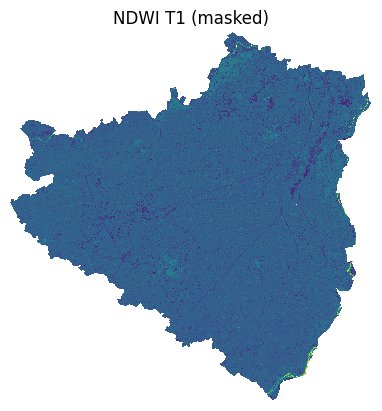

Saved: ndwi_t1.png


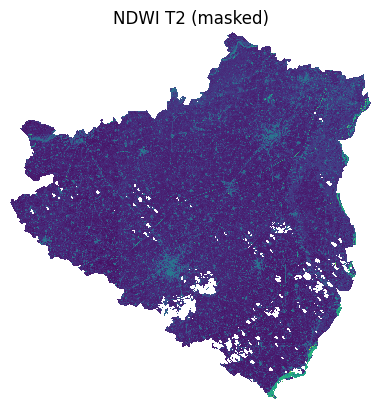

Saved: ndwi_t2.png


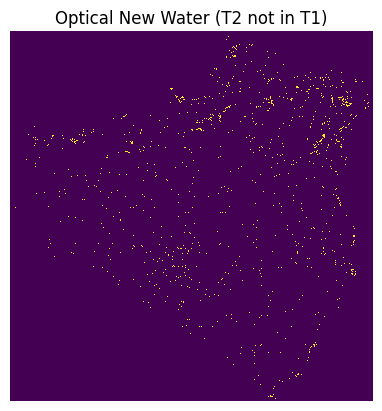

Saved: optical_new_water_mask.png


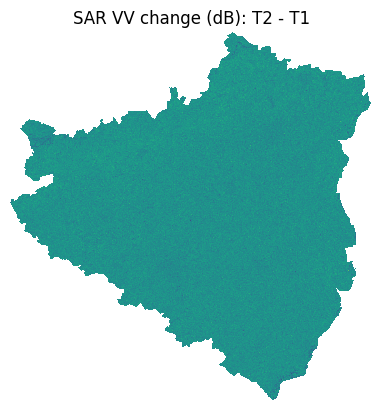

Saved: vv_change.png


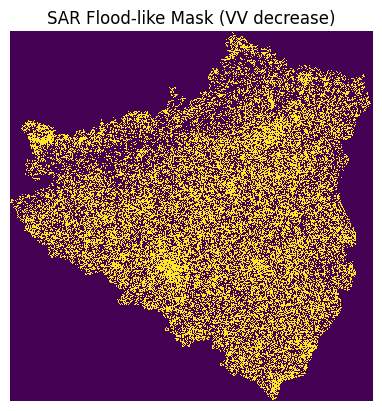

Saved: sar_flood_mask.png


In [9]:
def save_png(name, arr, title):
    plt.figure()
    plt.imshow(arr, interpolation="nearest")
    plt.title(title)
    plt.axis("off")
    out = out_fig / name
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", out.name)

save_png("ndwi_t1.png", NDWI_1, "NDWI T1 (masked)")
save_png("ndwi_t2.png", NDWI_2, "NDWI T2 (masked)")
save_png("optical_new_water_mask.png", OPT_NEW_WATER, "Optical New Water (T2 not in T1)")
save_png("vv_change.png", VV_change, "SAR VV change (dB): T2 - T1")
save_png("sar_flood_mask.png", SAR_FLOOD, "SAR Flood-like Mask (VV decrease)")


In [10]:
# pixel area from transform (meters). Because Step 4 is UTM 10m grid, this is reliable.
px_w = abs(s2_prof["transform"].a)
px_h = abs(s2_prof["transform"].e)
pixel_area_m2 = px_w * abs(px_h)

opt_area_km2 = OPT_NEW_WATER.sum() * pixel_area_m2 / 1e6
sar_area_km2 = SAR_FLOOD.sum() * pixel_area_m2 / 1e6

print("Pixel size (m):", px_w, "x", abs(px_h))
print("Optical new-water area (km^2):", opt_area_km2)
print("SAR flood-like area (km^2):", sar_area_km2)


Pixel size (m): 10.0 x 10.0
Optical new-water area (km^2): 35.5792
SAR flood-like area (km^2): 1155.6467
